
Прогнозирование с помощью экспоненциального сглаживания 



In [ ]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
matplotlib.style.use('ggplot')
%matplotlib inline
from statsmodels.tsa.api import ExponentialSmoothing

In [ ]:
df = pd.read_csv('wine_Austral2.dat', sep = "\t")
df

,fort,dry,sweet,red,rose,spark,total,year_,month_,date_
0,2585,1954,85,464,112,1686,15136,1980,1,JAN 1980
1,3368,2302,89,675,118,1591,16733,1980,2,FEB 1980
2,3210,3054,109,703,129,2304,20016,1980,3,MAR 1980
3,3111,2414,95,887,99,1712,17708,1980,4,APR 1980
4,3756,2226,91,1139,116,1471,18019,1980,5,MAY 1980
...,...,...,...,...,...,...,...,...,...,...
169,1568,3685,280,1728,35,1968,22784,1994,2,FEB 1994
170,1965,3754,187,2201,42,1720,23565,1994,3,MAR 1994
171,2659,3708,279,2455,48,1725,26323,1994,4,APR 1994
172,2354,3210,193,2204,44,1674,23779,1994,5,MAY 1994


Прогнозируем розовое вино.

In [ ]:
df_1 = df['rose']
df_1

0      112
1      118
2      129
3       99
4      116
      ... 
169     35
170     42
171     48
172     44
173     45
Name: rose, Length: 174, dtype: int64

In [ ]:
horizon = 8 #Количество месяцев для прогноза

In [ ]:
#Количество месяцев для тренировки
train_length = len(df_1) - horizon
#Делим на обучающее и тестовое множества 
df_train = df_1.iloc[0:train_length]
df_test = df_1.iloc[train_length:len(df_1)]

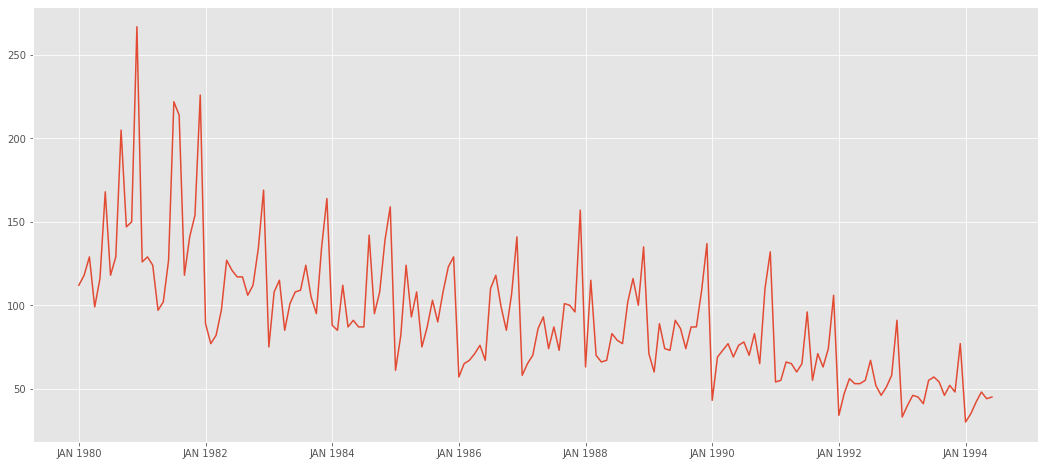

In [ ]:
df_2 = df['date_']
y_pos = np.arange(0, 174, 24)
plt.figure(figsize=(18, 8))

df_1.plot()

# Добавляем даты на график
plt.xticks(y_pos, df_2[y_pos])

plt.show()

1.  У временного ряда линейный тренд. <br>

2.  У временного ряда мультипликативная сезонность. <br>

3.  Ряд не меняет свой характер. <br>

4.  У ряда нет выбросов (высокие началные значения - результат мультпликативности). <br>

5.  У ряда нет пропусков. <br>


###  Приступаем к прогнозированию


In [ ]:
#  тип сезонности
season_type = 'multiplicative'
# период сезонных отклонений
seas_period_ = 12

По рекомендации Hyndman'а ставим тренд аддитивным, а damped = True

In [ ]:
fit1 = ExponentialSmoothing(df_train ,seasonal_periods=seas_period_ ,
                            trend='additive', seasonal=season_type, damped = True).fit()

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/holtwinters.py:712: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)


Предсказываем значения

In [ ]:
fitted_ = fit1.predict(0, len(df_train) + horizon - 1)

In [ ]:
fitted_

0      112.235423
1      118.454302
2      129.679828
3       99.632520
4      116.839288
          ...    
169     38.878800
170     44.836937
171     43.710468
172     41.766661
173     49.070742
Length: 174, dtype: float64

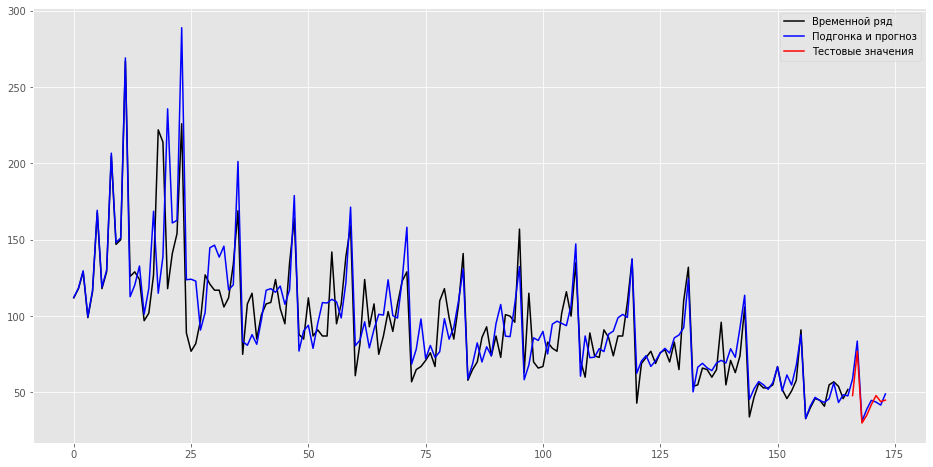

In [ ]:
plt.figure(figsize=(16,8))
plt.plot(df_train, label='Временной ряд', c = 'black')
plt.plot(fitted_, label='Подгонка и прогноз', c = 'blue')
plt.plot(df_test, label='Тестовые значения', c = 'red')
plt.legend(loc='best')
plt.show()

Данные первого года, как видно из графика, спрогнозированы точно (из-за наложения цветов может казаться, что временной ряд начинается на год позже, однако это обман зрения, я проверяла).

In [ ]:
#Прогноз для последних 8 месяцев
forecast_ = fitted_.iloc[len(df_train) : len(fitted_)]
forecast_

166    58.866315
167    83.667808
168    31.103365
169    38.878800
170    44.836937
171    43.710468
172    41.766661
173    49.070742
dtype: float64

In [ ]:
#   Оценим качество модели (ошибку прогноза), используя тестовое множество
MAPE_exp_smooth = np.mean(np.abs((forecast_.to_numpy() - df_test.to_numpy())/df_test.to_numpy()))*100
print("MAPE для экспоненциального сглаживания = ", MAPE_exp_smooth, '%')

MAPE для экспоненциального сглаживания =  9.483851835524138 %


В целом ошибку я считаю не такой уж большой. Спрогнозируем на 8 месяцев.

In [ ]:
pred_ = fit1.predict(len(df), len(df) + horizon-1)

In [ ]:
pred_

174    55.544083
175    46.631653
176    45.827346
177    46.443907
178    56.767287
179    80.830284
180    30.100287
181    37.686719
dtype: float64

<Figure size 1152x576 with 0 Axes>

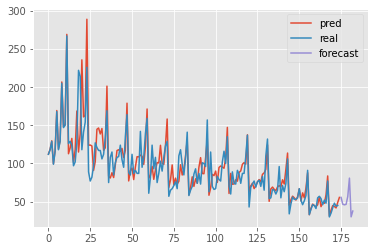

In [ ]:
pred = pd.DataFrame({
    'pred': fit1.predict(0, len(df)),
    'real': df_1})
pred['forecast'] = np.nan
df_2 = pd.DataFrame(pred_, columns=['forecast'])
df_2['real'] = np.nan
df_2['pred'] = np.nan
pred_1 = pd.concat(
    [pred, df_2],
    sort=False
).reset_index(drop=True)
plt.figure(figsize=(16,8))
pred_1.plot()